<a href="https://colab.research.google.com/github/swarnava-96/DNA-Sequence-Cassifier-using-NLP/blob/main/DNA_Sequence_Classifier_on_Human_Genes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DNA Sequence Classifier using NLP**
In this project, we will apply a Machine Learning Classification model on human gene sequences dataset that can predict genes function based on DNA sequence (coding sequence) alone.

### Importing the necessary libraries

In [1]:
cd "/content/drive/MyDrive/Datasets"

/content/drive/MyDrive/Datasets


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Loading the Data

In [3]:
human_data = pd.read_table("human_data.txt")
human_data.head()

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3


In [4]:
# Lets see the shape of the data

human_data.shape

(4380, 2)

We have some data for human DNA sequence coding regions and a class label. 
Let's define a function to collect all possible overlapping k-mers of a specified length from any sequence string. We will basically apply the k-mers to the complete sequences.

In [4]:
# Lets create a function to convert sequence strings into k-mer words, default size = 6 (Hexamer words)

def getKmers(sequence, size = 6):
  return [sequence[x : x + size].lower() for x in range(len(sequence) - size + 1)]

Now we can convert our training data sequences into short overlapping k-mers of legth 6.

In [6]:
human_data["words"] = human_data.apply(lambda x : getKmers(x["sequence"]), axis = 1)
human_data  = human_data.drop("sequence", axis = 1)

Now, our coding sequence data is changed to lowercase, split up into all possible k-mer words of length 6 and ready for the next step. Let's take a look.

In [7]:
human_data.head()

,class,words
0,4,"[atgccc, tgcccc, gcccca, ccccaa, cccaac, ccaac..."
1,4,"[atgaac, tgaacg, gaacga, aacgaa, acgaaa, cgaaa..."
2,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
3,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
4,3,"[atgcaa, tgcaac, gcaaca, caacag, aacagc, acagc..."


Since we are going to use scikit-learn natural language processing tools to do the k-mer counting, we need to now convert the lists of k-mers for each gene into string sentences of words that the count vectorizer can use. We can also make a y variable to hold the class labels.

In [8]:
human_texts = list(human_data["words"])
for item in range(len(human_texts)):
  human_texts[item] = " ".join(human_texts[item])

# Lets create our target feature
y_data = human_data.iloc[:, 0].values

In [9]:
# Lets check

print(human_texts[2])

atgtgt tgtgtg gtgtgg tgtggc gtggca tggcat ggcatt gcattt catttg atttgg tttggg ttgggc tgggcg gggcgc ggcgct gcgctg cgctgt gctgtt ctgttt tgtttg gtttgg tttggc ttggca tggcag ggcagt gcagtg cagtga agtgat gtgatg tgatga gatgat atgatt tgattg gattgc attgcc ttgcct tgcctt gccttt cctttc ctttct tttctg ttctgt tctgtt ctgttc tgttca gttcag ttcagt tcagtg cagtgt agtgtc gtgtct tgtctg gtctga tctgag ctgagt tgagtg gagtgc agtgct gtgcta tgctat gctatg ctatga tatgaa atgaag tgaaga gaagat aagatt agattg gattgc attgca ttgcac tgcaca gcacac cacaca acacag cacaga acagag cagagg agaggt gaggtc aggtcc ggtcca gtccag tccaga ccagat cagatg agatgc gatgca atgcat tgcatt gcattc cattcc attccg ttccgt tccgtt ccgttt cgtttt gttttg ttttga tttgag ttgaga tgagaa gagaat agaatg gaatgt aatgtc atgtca tgtcaa gtcaat tcaatg caatgg aatgga atggat tggata ggatac gataca atacac tacacc acacca caccaa accaac ccaact caactg aactgc actgct ctgctg tgctgc gctgct ctgctt tgcttt gctttg ctttgg tttgga ttggat tggatt ggattt gatttc atttca tttcac ttcacc tcaccg caccgg accggt

In [10]:
y_data

array([4, 4, 3, ..., 6, 6, 6])

Now, we will apply the BAG of WORDS using CountVectorizer. This is equivalent to k-mer counting. The n-gram size of 4 was previously determined by testing

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range = (4,4))
X = cv.fit_transform(human_texts)

In [13]:
# Lets see the shape of the vector X

X.shape

(4380, 232414)

If we have a look at class balance we can see we have relatively balanced dataset.

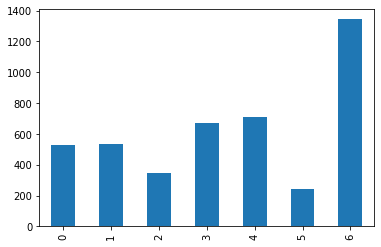

In [15]:
human_data["class"].value_counts().sort_index().plot.bar();

In [16]:
# Train test split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size = 0.20, random_state = 42)

In [17]:
# Lets see the shape of the train and test datasets
print(X_train.shape)
print(X_test.shape)

(3504, 232414)
(876, 232414)


A multinomial naive Bayes classifier will be created. I previously did some parameter tuning and found the ngram size of 4 (reflected in the Countvectorizer() instance) and a model alpha of 0.1 did the best.

In [20]:
from sklearn.naive_bayes import  MultinomialNB
classifier = MultinomialNB(alpha = 0.1)
classifier.fit(X_train, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [21]:
# Prediction

y_pred = classifier.predict(X_test)

Okay, so let's look at some model performce metrics like the confusion matrix, accuracy, precision, recall and f1 score. We are getting really good results on our unseen data, so it looks like our model did not overfit to the training data.

In [23]:
# Validation

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("Confusion Matrix\n")
print(pd.crosstab(pd.Series(y_test, name = "Actual"), pd.Series(y_pred, name = "Predicted")))
def get_metrics(y_test, y_predicted):
  accuracy = accuracy_score(y_test, y_predicted)
  precision = precision_score(y_test, y_predicted, average = "weighted")
  recall = recall_score(y_test, y_predicted, average = "weighted")
  f1 = f1_score(y_test, y_predicted, average = "weighted")

  return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion Matrix

Predicted   0    1   2    3    4   5    6
Actual                                   
0          99    0   0    0    1   0    2
1           0  104   0    0    0   0    2
2           0    0  78    0    0   0    0
3           0    0   0  124    0   0    1
4           1    0   0    0  143   0    5
5           0    0   0    0    0  51    0
6           1    0   0    1    0   0  263
accuracy = 0.984 
precision = 0.984 
recall = 0.984 
f1 = 0.984


We can conclude that the model performed really well from the above metrics scores.